In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv" ,encoding="cp949")
test = pd.read_csv("../input/test.csv" ,encoding="cp949")

In [3]:
y_all = ['Y02', 'Y04', 'Y09','Y07','Y05','Y15','Y16']

In [4]:
train_temp_median = train.loc[:, y_all].median(axis=1) #y00~y17의 중앙값
train_temp_median
train["Y18"] = train_temp_median # y18의 30일치 결측치에, y00~y17의 중앙값을 추가

In [5]:
temperature    = ["X00","X07"] # 기온
local_press    = ["X22"] # 현지기압
wind_speed     = ["X26"] # 풍속
acc_rainfall   = ["X10","X39"] # 누적강수량
sea_pressure   = ["X08"] # 해면기압
acc_solar      = ["X34"] # 누적일사량
humidity       = ["X12","X20"] # 습도
wind_direction = ["X25"] # 풍향
X_all = list(train[["X00","X07","X32","X31","X22","X26","X10","X39","X08","X34","X12","X20","X25"]]) 

In [6]:
# X 컬럼만 표준화 하는 이유 : 각 독립변수마다 단위가 다르기 때문. 값이나 표준편차가 크면 당연히 영향이 크게 나오고 모델에 문제가 발생
from sklearn.preprocessing import StandardScaler  
StdScaler = StandardScaler()

# 트레이닝 데이터 변환하기, 사용한 스탠다드 스케일러로 테스트 데이터 변환하기
train_X_normed = StdScaler.fit_transform( train[X_all] ) #Array로 변환                                     
test_X_normed = StdScaler.transform(test[X_all])

train_X_normed = pd.DataFrame(columns=X_all, data = train_X_normed) # 컬럼별 N(μ,σ^2)로 변환됩니다.
test_X_normed = pd.DataFrame(columns=X_all, data = test_X_normed)

In [7]:
# temperature, local_press, wind_speed, acc_rainfall, sea_pressure, acc_solar, humidity, wind_direction

temperature_m = pd.DataFrame(train_X_normed[temperature].mean(axis = 1))
local_press_m = pd.DataFrame(train_X_normed[local_press].mean(axis = 1))
wind_speed_m  = pd.DataFrame(train_X_normed[wind_speed].mean(axis = 1))
acc_rainfall_m  = pd.DataFrame(train_X_normed[acc_rainfall].mean(axis = 1)) #강수량은 drop시키거나 T/F로 변경예정
sea_pressure_m  = pd.DataFrame(train_X_normed[sea_pressure].mean(axis = 1))
acc_solar_m  = pd.DataFrame(train_X_normed[acc_solar].mean(axis = 1))
humidity_m  = pd.DataFrame(train_X_normed[humidity].mean(axis = 1))
wind_direction_m  = pd.DataFrame(train_X_normed[wind_direction].mean(axis = 1))

m_train = pd.concat([train[['Y18']], temperature_m, local_press_m, wind_speed_m, acc_rainfall_m,
              sea_pressure_m, acc_solar_m, humidity_m, wind_direction_m], axis=1).dropna().reset_index(drop=True)
m_train.columns = ["Y18", "temperature_m", "local_press_m", "wind_speed_m", "acc_rainfall_m",
              "sea_pressure_m", "acc_solar_m", "humidity_m", "wind_direction_m"]


temperature_m = pd.DataFrame(test_X_normed[temperature].mean(axis = 1))
local_press_m = pd.DataFrame(test_X_normed[local_press].mean(axis = 1))
wind_speed_m  = pd.DataFrame(test_X_normed[wind_speed].mean(axis = 1))
acc_rainfall_m  = pd.DataFrame(test_X_normed[acc_rainfall].mean(axis = 1)) #강수량은 drop시키거나 T/F로 변경예정
sea_pressure_m  = pd.DataFrame(test_X_normed[sea_pressure].mean(axis = 1))
acc_solar_m  = pd.DataFrame(test_X_normed[acc_solar].mean(axis = 1))
humidity_m  = pd.DataFrame(test_X_normed[humidity].mean(axis = 1))
wind_direction_m  = pd.DataFrame(test_X_normed[wind_direction].mean(axis = 1))

m_test = pd.concat([temperature_m, local_press_m, wind_speed_m, acc_rainfall_m,
              sea_pressure_m, acc_solar_m, humidity_m, wind_direction_m], axis=1).dropna().reset_index(drop=True)
m_test.columns = ["temperature_m", "local_press_m", "wind_speed_m", "acc_rainfall_m",
              "sea_pressure_m", "acc_solar_m", "humidity_m", "wind_direction_m"]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

C:\Users\0114m\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\0114m\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [9]:
X_00_39_y18 = pd.concat([train_X_normed, train[['Y18']]], axis=1).dropna().reset_index(drop=True)

In [10]:
# 전체 표준화 한 데이터
X_train = X_00_39_y18.iloc[:,:-1]
Y_train = X_00_39_y18.iloc[:,-1]
X_test = test_X_normed

In [11]:
# Feature Engineering 한 데이터
X_train_FE = m_train.iloc[:,1:]
Y_train_FE = m_train.iloc[:,0]
X_test_FE = m_test

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1)
X_train_FE, X_val_FE, Y_train_FE, Y_val_FE = train_test_split(X_train_FE, Y_train_FE, test_size=0.3, random_state=1)

In [12]:
param_list = {"n_estimators": list(range(5, 100, 5)),
              "max_depth": [4, 8, 12, 16, 20],
              "max_features": list(range(2, 14, 2)),
              "min_samples_split": list(range(2, 14, 2))}

Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 42.8422
[20]	valid_0's l2: 35.3136
[30]	valid_0's l2: 29.1484
[40]	valid_0's l2: 24.1354
[50]	valid_0's l2: 20.0027
[60]	valid_0's l2: 16.6149
[70]	valid_0's l2: 13.8167
[80]	valid_0's l2: 11.5143
[90]	valid_0's l2: 9.62836
[100]	valid_0's l2: 8.07271
[110]	valid_0's l2: 6.80525
[120]	valid_0's l2: 5.75138
[130]	valid_0's l2: 4.88556
[140]	valid_0's l2: 4.17435
[150]	valid_0's l2: 3.57361
[160]	valid_0's l2: 3.07882
[170]	valid_0's l2: 2.66953
[180]	valid_0's l2: 2.33488
[190]	valid_0's l2: 2.05447
[200]	valid_0's l2: 1.81945
[210]	valid_0's l2: 1.63031
[220]	valid_0's l2: 1.46988
[230]	valid_0's l2: 1.33559
[240]	valid_0's l2: 1.22355
[250]	valid_0's l2: 1.12989
[260]	valid_0's l2: 1.0537
[270]	valid_0's l2: 0.987113
[280]	valid_0's l2: 0.928871
[290]	valid_0's l2: 0.877515
[300]	valid_0's l2: 0.835959
[310]	valid_0's l2: 0.798936
[320]	valid_0's l2: 0.765438
[330]	valid_0's l2: 0.737913
[340]	valid_0's l

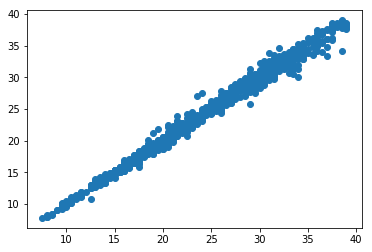

R_Squared : 0.9912853162283262
MSE :  0.4528391089881614
RMSE :  0.6729332128734332


In [13]:
train_ds = lgb.Dataset(X_train, label = Y_train)
val_ds = lgb.Dataset(X_val, label = Y_val)

params = {'learning_rate': 0.01, 'max_depth': 16, 
          'boosting': 'gbdt', 'objective': 'regression', 
          'metric': 'mse', 'is_training_metric': True,
          'num_leaves': 144, 'feature_fraction': 0.9,
          'bagging_fraction': 0.7, 'bagging_freq': 5, 'seed':1}

lgb = lgb.train(params, train_ds, 1000, val_ds, verbose_eval=10, early_stopping_rounds=100)

y_pred_train_7 = lgb.predict(X_val)
plt.scatter(Y_val, y_pred_train_7)
plt.show()
print("R_Squared :", r2_score(Y_val, y_pred_train_7))

mse = mean_squared_error(Y_val, y_pred_train_7)
print("MSE : ", mse)
print("RMSE : ", mse ** 0.5)

Text(0, 0.5, 'temperature')

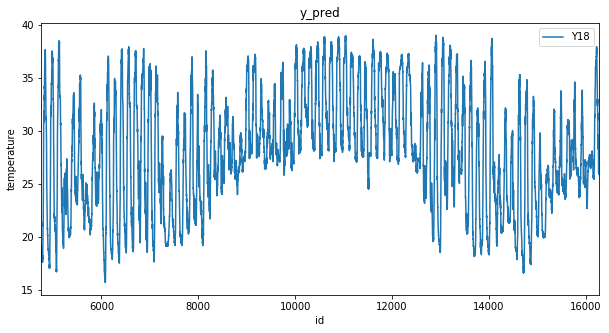

In [14]:
import time
now = time.strftime('%Y-%m-%d_%H;%M;%S', time.localtime(time.time()))

data = lgb.predict(X_test) # 특징추출하지않은 lightGBM모델과 test셋을 가져와서 예측값을 냄
csv_dict = {'id':test['id'], 'Y18':data} # 딕셔너리 화
sub = pd.DataFrame(csv_dict)             # 데이터프레임화

sub.to_csv("../input/{}_submission.csv".format(now),index=False) #저장

sub.plot(x="id", y='Y18', figsize=(10,5), title="y_pred")
plt.ylabel("temperature")